In [36]:
import os
import sys
import glob
import subprocess

import numpy as np
import pandas as pd
from scipy.signal import find_peaks

import torch

import matplotlib.pyplot as plt

In [ ]:
def zscore(data):
    return (data - np.mean(data))/np.std(data)

In [ ]:
def load_ch_table(fn):

# チャネルID 収録フラグ 回線遅延時間 観測点コード 成分コード モニタ波形振幅縮率 量子化ビット数 センサー感度 入力振幅単位 固有周期 ダンピング 電圧増幅率(dB) 1量子化ステップ幅 緯度 経度 海抜高度 P波観測点補正 S波観測点補正 観測点名 組織名
#"ChID", "flag", "delay","st_code", "comp_code", "monitor_amp","bit","sensitivity", "unit","nat_period", "damping", "gain_dB","step_width","lon", "lat","z", "P_cor", "S_cor", "st_name", "Institute"]

    output_list = []

    with open(fn, "r") as f:
        for line in f:
            output = []
            if not line.isspace():
                if '#' not in line.split()[0]:
                    
                    try:
                        
                        output = [line.split()[0], 
                                line.split()[1], 
                                line.split()[2], 
                                line.split()[3], 
                                line.split()[4], 
                                line.split()[5], 
                                line.split()[6], 
                                float(line.split()[7]), 
                                line.split()[8], 
                                line.split()[9], 
                                line.split()[10], 
                                float(line.split()[11]),
                                float(line.split()[12])]

                        if line.split()[4] == 'U' or line.split()[4] == 'wU' or line.split()[4] == 'UA' or line.split()[4] == 'VL' or line.split()[4] == 'V':
                            if '-' in line.split()[14]:
                                output.append(float(line.split()[13]))
                                output.append(float(line.split()[14].split('-')[0]))
                                output.append(float('-' + line.split()[14].split('-')[1]))
                            else:
                                output.append(float(line.split()[13]))
                                output.append(float(line.split()[14]))
                                output.append(float(line.split()[15]))
                        else:
                            output.append(0)
                            output.append(0)
                            output.append(0)
                        
                        output_list.append(output)
                        
                    except:
                        continue
    
    df = pd.DataFrame(output_list, columns=['ChID', 'flag', 'delay', 'stname', 'comp', 'monitor_amp', 'bit', 'sensitivity', 'unit', 'nat_period', 'damping', 'gain_dB', 'step_width', 'lat', 'lon', 'elv'])
    return df

In [ ]:
def win2ndarray(path):

    chtable_path = path + '.ch'

    df=load_ch_table(chtable_path)

    ch = df['ChID'].values
    stations = df['stname'].values
    comp = df['comp'].values

    wave_100Hz_list = []
    wave_250Hz_list = []
    wave_M01_list = []
    
    station_100Hz = []
    station_250Hz = []
    station_M01 = []
    
    station = np.array(list(dict.fromkeys(stations)))

    for i in range(len(station)):
        
        if 'DP.' in station[i]:
        
            ch_num = len(np.where((stations==station[i]))[0])
            
            if ch_num == 3:
                    
                ud_idx = np.where((stations==station[i]) & (comp=="U"))[0][0]
                ns_idx = np.where((stations==station[i]) & (comp=="N"))[0][0]
                ew_idx = np.where((stations==station[i]) & (comp=="E"))[0][0]

                ch_ud = ch[ud_idx]
                ch_ns = ch[ns_idx]
                ch_ew = ch[ew_idx]
                
                # UD
                result1 = subprocess.run(['dewin', '-en', ch_ud, path], capture_output=True, text=True).stdout
                array = np.fromstring(result1, sep=' ', dtype=float)
                obs_time, ud = np.reshape(array, (-1, 2)).T
                
                if len(obs_time) == 0:
                    continue
            
                # NS
                result2 = subprocess.run(['dewin', '-cn', ch_ns, path], capture_output=True, text=True).stdout
                ns = np.fromstring(result2, sep='\n', dtype=float)
                
                # EW
                result3 = subprocess.run(['dewin', '-cn', ch_ew, path], capture_output=True, text=True).stdout
                ew = np.fromstring(result3, sep='\n', dtype=float)
                
                if obs_time[1] == 0.01:
                    
                    wave = np.zeros((3, 3000), dtype='float32')
                    wave[0,:] = zscore(ud[1000:4000])
                    wave[1,:] = zscore(ns[1000:4000])
                    wave[2,:] = zscore(ew[1000:4000])
                    
                    wave_100Hz_list.append(wave)
                    station_100Hz.append(station[i])
                    
                elif obs_time[1] == 0.004:
                    
                    wave = np.zeros((3, 7500), dtype='float32')
                    wave[0,:] = zscore(ud[2500:10000])
                    wave[1,:] = zscore(ns[2500:10000])
                    wave[2,:] = zscore(ew[2500:10000])
                    
                    wave_250Hz_list.append(wave)
                    station_250Hz.append(station[i])
                
            elif ch_num == 1:
                
                ud_idx = np.where((stations==station[i]) & (comp=="U"))[0][0]

                ch_ud = ch[ud_idx]
                
                # UD
                result1 = subprocess.run(['dewin', '-en', ch_ud, path], capture_output=True, text=True).stdout
                array = np.fromstring(result1, sep=' ', dtype=float)
                obs_time, ud = np.reshape(array, (-1, 2)).T
                
                if len(obs_time) == 0:
                    continue
            
                wave = np.zeros((1, 3000), dtype='float32')
                wave[0,:] = zscore(ud[1000:4000])
                
                wave_M01_list.append(wave)
                station_M01.append(station[i])
                
    return station_250Hz, np.stack(wave_250Hz_list), station_100Hz, np.stack(wave_100Hz_list), station_M01, np.stack(wave_M01_list)

In [ ]:
device = torch.device('cpu')

sys.path.append('./model/')
from model_str import Model
sys.path.pop()
model250 = Model(in_length=250*30, in_channels=3, class_num=3, strides=[5,3,2], kernel_size=5)
model250.load_state_dict(torch.load('./model/model_250Hz.pth', map_location=device))
model250.eval()

model100 = Model(in_length=100*30, in_channels=3, class_num=3, strides=[3,2,2], kernel_size=3)
model100.load_state_dict(torch.load('./model/model_100Hz.pth', map_location=device))
model100.eval()

modelM01 = Model(in_length=100*30, in_channels=1, class_num=2, strides=[3,2,2], kernel_size=3)
modelM01.load_state_dict(torch.load('./model/model_M01.pth', map_location=device))
modelM01.eval()

In [ ]:
station_250Hz, wave_250Hz, station_100Hz, wave_100Hz, station_M01, wave_M01 = win2ndarray('/home/user/Desktop/SegPhase/test_data/180805.090417')

with torch.no_grad():
    pred_250Hz = model250(torch.tensor(wave_250Hz).float()).detach().cpu().numpy()
    pred_100Hz = model100(torch.tensor(wave_100Hz).float()).detach().cpu().numpy()
    pred_M01 = modelM01(torch.tensor(wave_M01).float()).detach().cpu().numpy()

In [ ]:
print("wave_250Hz shape:", wave_250Hz.shape)
print("wave_100Hz shape:", wave_100Hz.shape)
print("wave_M01 shape:", wave_M01.shape)

In [63]:
print("wave_250Hz type:", type(wave_250Hz))
print("wave_100Hz type:", type(wave_100Hz))
print("wave_M01 type:", type(wave_M01))

wave_250Hz type: <class 'numpy.ndarray'>
wave_100Hz type: <class 'numpy.ndarray'>
wave_M01 type: <class 'numpy.ndarray'>


In [ ]:
lapse_time = np.arange(0,30,0.01)

for i in range(wave_100Hz.shape[0]):
    fig = plt.figure(figsize=(16,6))
    plt.subplot(4,1,1)
    plt.plot(lapse_time, wave_100Hz[i][0,:])
    plt.xlim(0,30)
    plt.subplot(4,1,2)
    plt.plot(lapse_time, wave_100Hz[i][1,:])
    plt.xlim(0,30)
    plt.subplot(4,1,3)
    plt.plot(lapse_time, wave_100Hz[i][2,:])
    plt.xlim(0,30)
    plt.subplot(4,1,4)
    plt.plot(lapse_time, pred_100Hz[i][0,:])
    plt.plot(lapse_time, pred_100Hz[i][1,:])
    plt.xlim(0,30)
    plt.ylim(0,1)
    
    plt.show()
    plt.close()

In [ ]:
lapse_time = np.arange(0,30,0.004)

for i in range(wave_250Hz.shape[0]):
    fig = plt.figure(figsize=(16,6))
    plt.subplot(4,1,1)
    plt.plot(lapse_time, wave_250Hz[i][0,:])
    plt.xlim(0,30)
    plt.subplot(4,1,2)
    plt.plot(lapse_time, wave_250Hz[i][1,:])
    plt.xlim(0,30)
    plt.subplot(4,1,3)
    plt.plot(lapse_time, wave_250Hz[i][2,:])
    plt.xlim(0,30)
    plt.subplot(4,1,4)
    plt.plot(lapse_time, pred_250Hz[i][0,:])
    plt.plot(lapse_time, pred_250Hz[i][1,:])
    plt.xlim(0,30)
    plt.ylim(0,1)
    
    plt.show()
    plt.close()

In [ ]:
for i in range(wave_M01.shape[0]):
    fig = plt.figure(figsize=(16,3))
    plt.subplot(2,1,1)
    plt.plot(wave_M01[i][0,:])
    plt.subplot(2,1,2)
    plt.plot(pred_M01[i][0,:])
    plt.ylim(0,1)
    plt.show()
    plt.close()

In [60]:
def plot_wave(ax, lapse_time, wave, pidxs, sidxs, sf, ylabel):
    
    ax.plot(lapse_time, wave, c='black', lw=0.6)
    
    for i in range(len(pidxs)):
        ax.axvline(x=pidxs[i]*sf, c='blue', lw=0.8)
        
    for i in range(len(sidxs)):
        ax.axvline(x=sidxs[i]*sf, c='red', lw=0.8)
    
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xticks([])
    
    ax.set_xlim(0, 30)
    return

def plot_pred(ax, lapse_time, pred, idxs, phase, sf):
    
    if phase == 'P':
        ylabel = 'P-wave Pred.'
        c = 'blue'
    elif phase == 'S':
        ylabel = 'S-wave Pred.'
        c = 'red'
    
    ax.plot(lapse_time, pred, c=c, lw=0.8, label=ylabel)
    
    for i in range(len(idxs)):
        ax.axvline(x=idxs[i]*sf, c=c, lw=0.8)
    
    ax.set_xlim(0, 30)
    
    ax.set_xlabel('Time (s)', fontsize=16)
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    ax.set_ylim(0,1)
    
    return

def plot_result_3C(wave, pred, station, sf):
    
    lapse_time = np.arange(0,30,sf)
        
    pidxs, p_probs = find_peaks(pred[0,:], distance=int(1/sf), height=0.1)
    sidxs, s_probs = find_peaks(pred[1,:], distance=int(1/sf), height=0.1)

    fig = plt.figure(figsize=(8,4))
    
    ax1 = fig.add_subplot(4, 1, 1)
    plot_wave(ax1, lapse_time, wave[0,:], pidxs, sidxs, sf, 'UD')
    
    ax2 = fig.add_subplot(4, 1, 2)
    plot_wave(ax2, lapse_time, wave[1,:], pidxs, sidxs, sf, 'NS')
    
    ax3 = fig.add_subplot(4, 1, 3)
    plot_wave(ax3, lapse_time, wave[2,:], pidxs, sidxs, sf, 'EW')
    
    ax4 = fig.add_subplot(4, 1, 4)
    plot_pred(ax4, lapse_time, pred[0,:], pidxs, 'P', sf)
    plot_pred(ax4, lapse_time, pred[1,:], sidxs, 'S', sf)
    ax4.legend()
    
    ax1.set_title(station, fontsize=18)
  
    plt.subplots_adjust(hspace=0.2)
    
    ax1.set_ylabel('UD', fontsize=16)
    ax2.set_ylabel('NS', fontsize=16)
    ax3.set_ylabel('EW', fontsize=16)
    ax4.set_ylabel('Prob.', fontsize=16)
    
    ax1.yaxis.set_label_coords(-0.08, 0.5)
    ax2.yaxis.set_label_coords(-0.08, 0.5)
    ax3.yaxis.set_label_coords(-0.08, 0.5)
    ax4.yaxis.set_label_coords(-0.08, 0.5)

    plt.show()
    plt.close()
    return

def plot_result_1C(wave, pred, station, sf):
    
    lapse_time = np.arange(0,30,sf)
        
    pidxs, p_probs = find_peaks(pred[0,:], distance=int(1/sf), height=0.1)
    sidxs = []
    
    fig = plt.figure(figsize=(8,2))
    
    ax1 = fig.add_subplot(2, 1, 1)
    plot_wave(ax1, lapse_time, wave[0,:], pidxs, sidxs, sf, 'UD')
    
    ax2 = fig.add_subplot(2, 1, 2)
    plot_pred(ax2, lapse_time, pred[0,:], pidxs, 'P', sf)
    ax2.legend()
    
    ax1.set_title(station, fontsize=18)
  
    plt.subplots_adjust(hspace=0.2)
    
    ax1.set_ylabel('UD', fontsize=16)
    ax2.set_ylabel('Prob.', fontsize=16)
    
    ax1.yaxis.set_label_coords(-0.08, 0.5)
    ax2.yaxis.set_label_coords(-0.08, 0.5)

    plt.show()
    plt.close()
    return

In [ ]:
for i in range(wave_250Hz.shape[0]):
    plot_result_3C(wave_250Hz[i], pred_250Hz[i], station_250Hz[i], 0.004)

In [ ]:
for i in range(wave_M01.shape[0]):
    plot_result_1C(wave_M01[i], pred_M01[i], station_M01[i], 0.01)

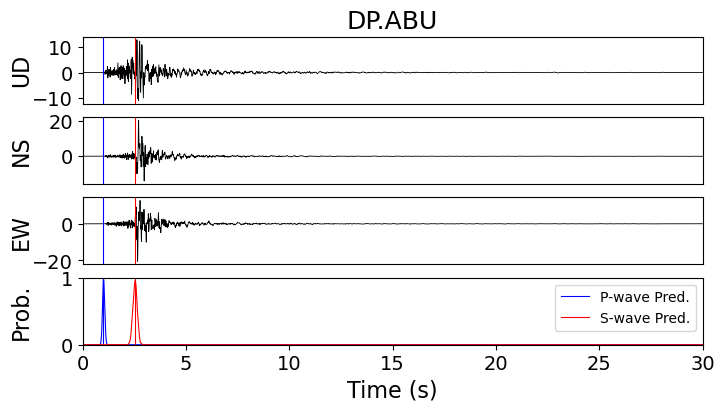

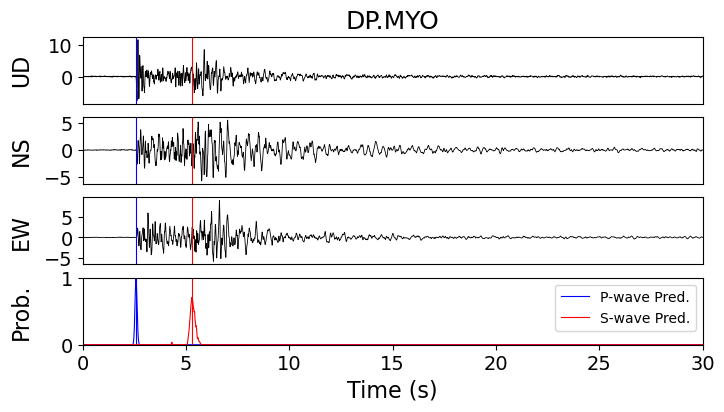

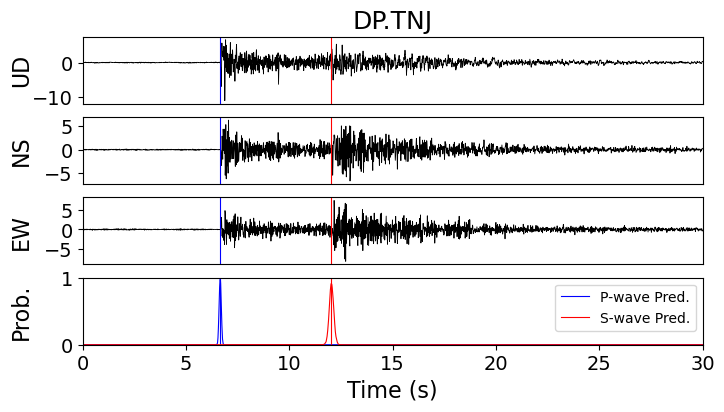

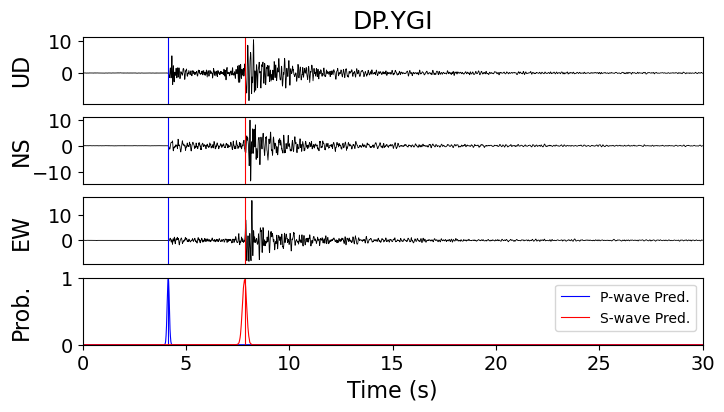

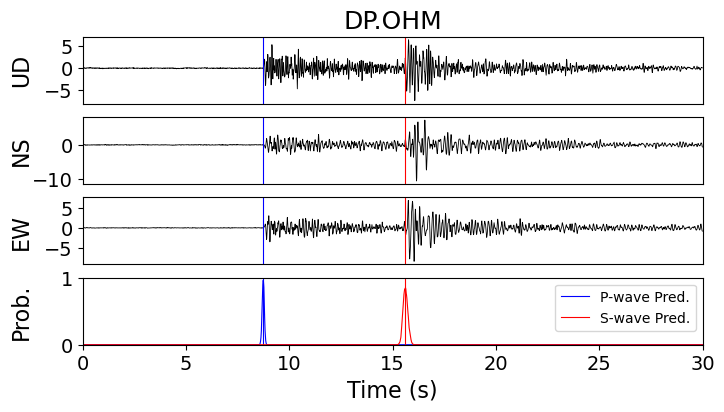

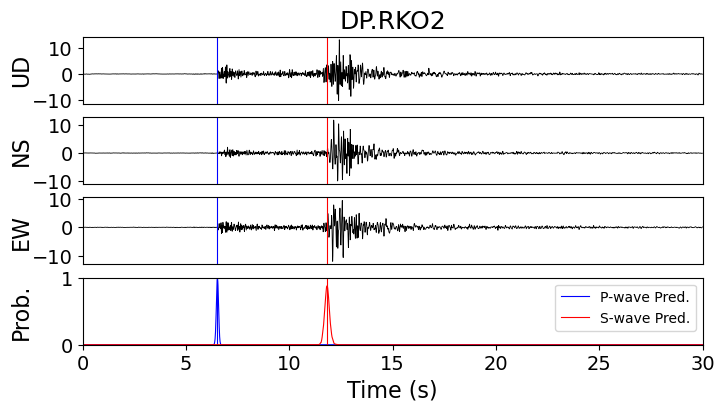

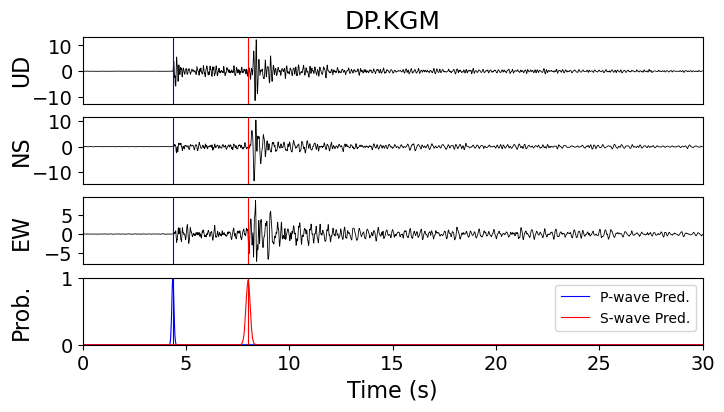

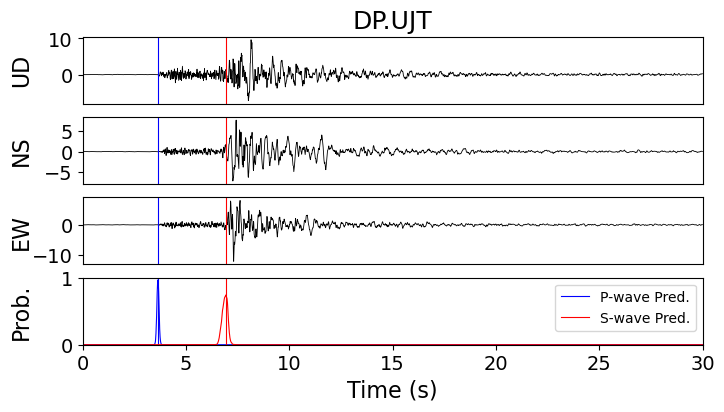

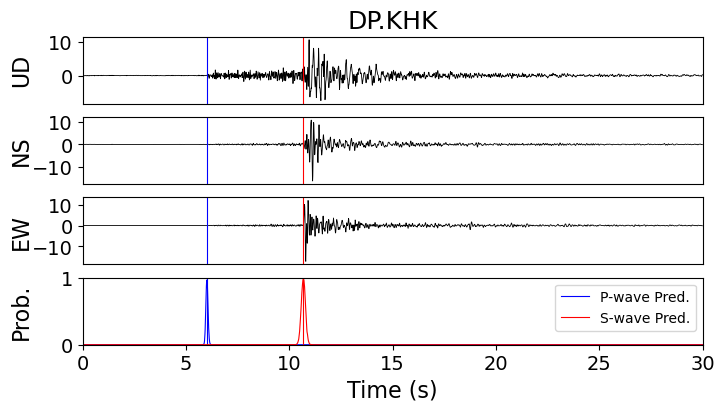

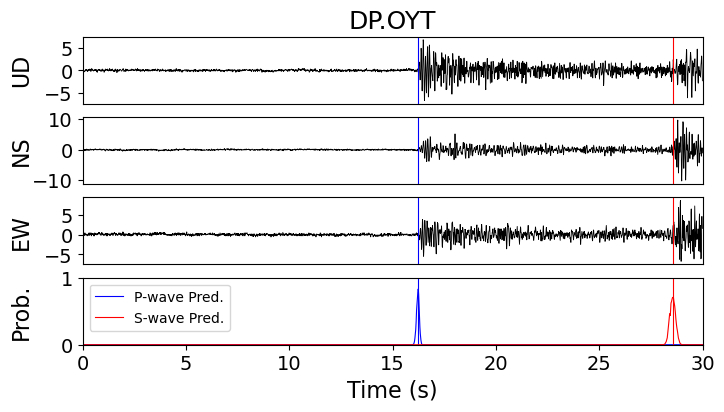

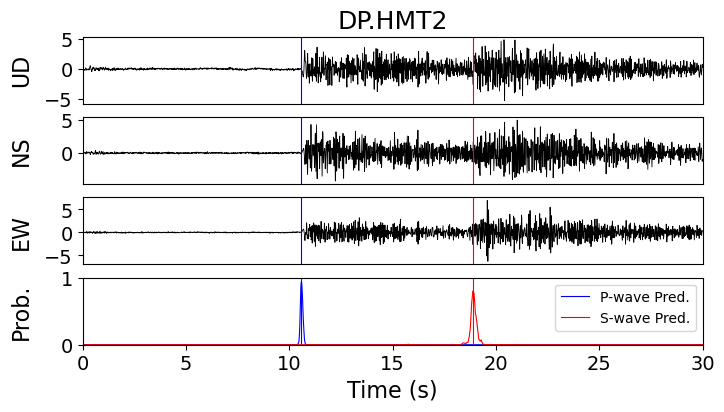

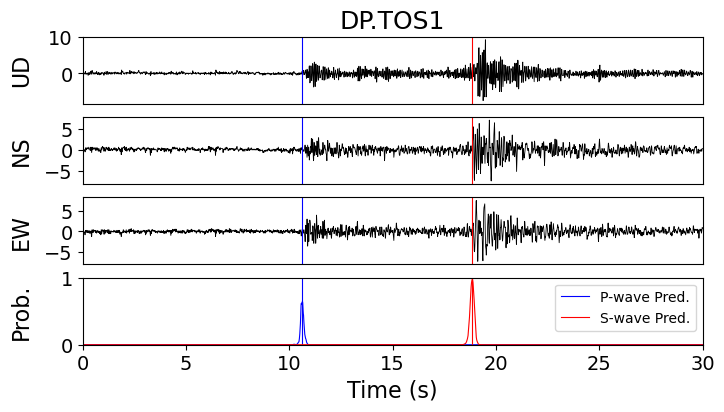

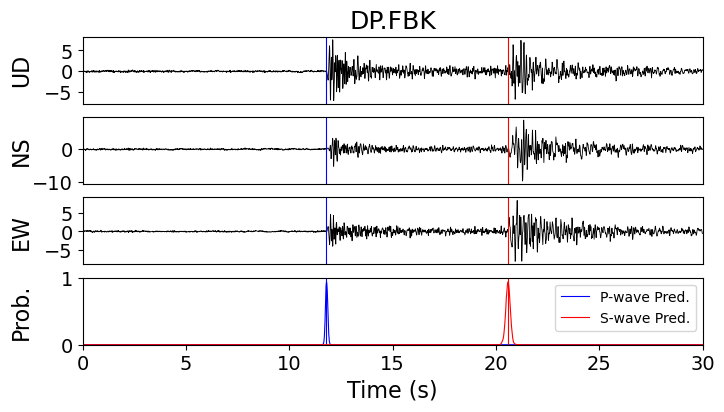

In [64]:
for i in range(wave_100Hz.shape[0]):
        plot_result_3C(wave_100Hz[i], pred_100Hz[i], station_100Hz[i], 0.01)